# Precipitation Frequency Table For Nested Hyetograph

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each recurrence interval hyetograph shape 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import* #Using new hydromet_stratified
from hydromet_stratified import* #Using new hydromet_stratified

### Parameters: 

#### Papermill (site specific):

In [2]:

## Filenames and fields:
Project_Area = 'DesPlaines'          # Project area name
Pluvial_Model = 'P03'                # Pluvial model name
BCN = 'D01'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'Addison_domain.shp'           # Shapefile name
filter_field = 'Domain'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = BCN                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [3]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)
polygon_dir

WindowsPath('C:/Users/mbartlettjr/Documents/GitHub/pfra-hydromet/Notebooks/pluvial/Inputs/Addison_domain.shp')

#### Global (project specific):

In [4]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h','24h'] #'05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h' ,'04d'
dur_names = ['5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr','24hr']  # '5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr',  '96hr'

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.read_file(polygon_dir)
check_attributes(gdf)

gdf.head(1)

,Domain,Centroid_X,Centroid_Y,geometry
0,D01,-87.911686,41.900325,"POLYGON ((1085471.218 1928481.372, 1085503.920..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [6]:
print('Original Coordinate Reference System:', gdf.crs)
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))
        
vector_crs_prj =gdf.crs

Original Coordinate Reference System: epsg:6455
Vector Layer crs = +proj=tmerc +lat_0=36.6666666666667 +lon_0=-88.3333333333333 +k=0.999975 +x_0=300000 +y_0=0 +ellps=GRS80 +units=us-ft +no_defs


C:\Users\mbartlettjr\Anaconda\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Extract the area of interest, reproject, and plot:

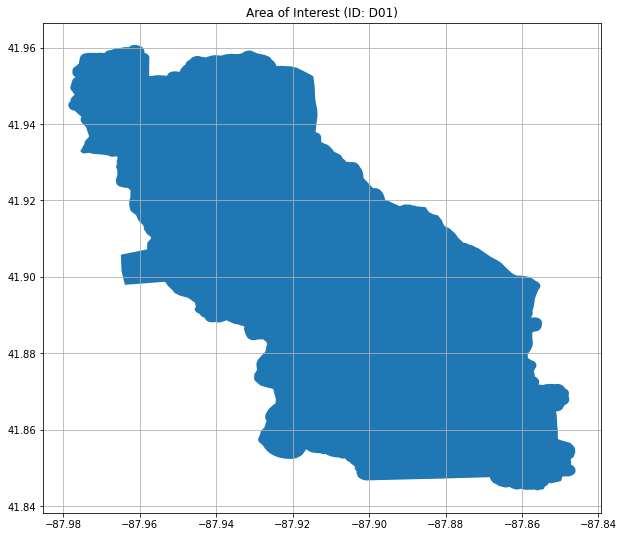

In [7]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj
    
geo_df = gdf1.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           2
Region           1
Percent_area     100.0


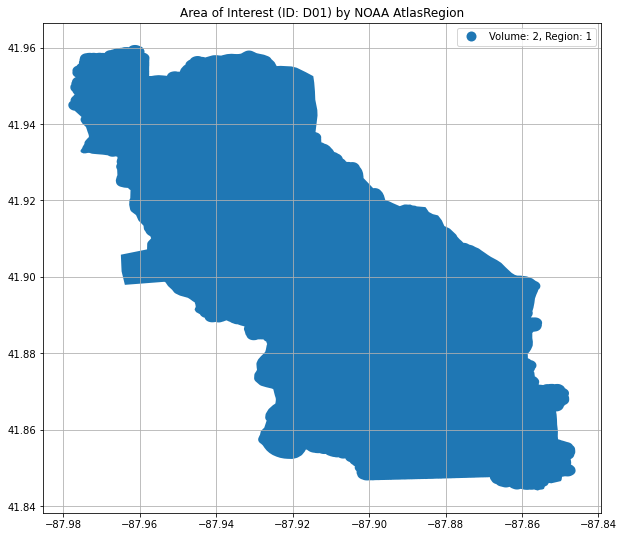

In [8]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [9]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: orb


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [10]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d) and ('l.zip' not in d) and ('u.zip' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

#Added by Mark Bartlett 
#Parse out the file name by using split functions
for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

10 files found for 05m
10 files found for 10m
10 files found for 15m
10 files found for 30m
10 files found for 60m
10 files found for 02h
10 files found for 03h
10 files found for 06h
10 files found for 12h
10 files found for 24h


### Iterate through zip files and build a table:

In [11]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 orb1yr05ma.zip
1 orb2yr05ma.zip
2 orb5yr05ma.zip
3 orb10yr05ma.zip
4 orb25yr05ma.zip
5 orb50yr05ma.zip
6 orb100yr05ma.zip
7 orb200yr05ma.zip
8 orb500yr05ma.zip
9 orb1000yr05ma.zip
10 orb1yr10ma.zip
11 orb2yr10ma.zip
12 orb5yr10ma.zip
13 orb10yr10ma.zip
14 orb25yr10ma.zip
15 orb50yr10ma.zip
16 orb100yr10ma.zip
17 orb200yr10ma.zip
18 orb500yr10ma.zip
19 orb1000yr10ma.zip
20 orb1yr15ma.zip
21 orb2yr15ma.zip
22 orb5yr15ma.zip
23 orb10yr15ma.zip
24 orb25yr15ma.zip
25 orb50yr15ma.zip
26 orb100yr15ma.zip
27 orb200yr15ma.zip
28 orb500yr15ma.zip
29 orb1000yr15ma.zip
30 orb1yr30ma.zip
31 orb2yr30ma.zip
32 orb5yr30ma.zip
33 orb10yr30ma.zip
34 orb25yr30ma.zip
35 orb50yr30ma.zip
36 orb100yr30ma.zip
37 orb200yr30ma.zip
38 orb500yr30ma.zip
39 orb1000yr30ma.zip
40 orb1yr60ma.zip
41 orb2yr60ma.zip
42 orb5yr60ma.zip
43 orb10yr60ma.zip
44 orb25yr60ma.zip
45 orb50yr60ma.zip
46 orb100yr60ma.zip
47 orb200yr60ma.zip
48 orb500yr60ma.zip
49 orb1000yr60ma.zip
50 orb1yr02ha.zip
51 orb2yr02ha.zip
52 orb5yr02ha.

,region,TR,duration,statistic,value
0,orb,1,05m,Expected Value,0.386906
1,orb,2,05m,Expected Value,0.454547
2,orb,5,05m,Expected Value,0.535068
3,orb,10,05m,Expected Value,0.611145
4,orb,25,05m,Expected Value,0.700829


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [12]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

---

## Calculate NRCS nested hyetograph function 

In [35]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in c_df.index.astype(str).tolist()[1:10]:
    precip_df = c_df.loc[evnt][['duration','value']].set_index('duration')
    hyetos[evnt] = precip_hyetograph_nrcs(precip_df)   

#### Plot to check

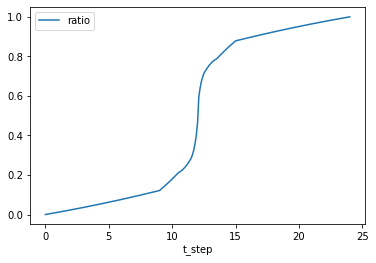

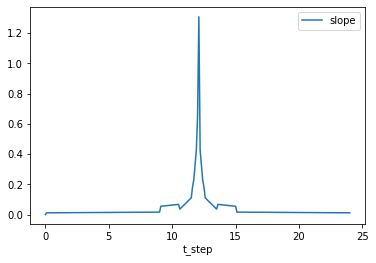

In [14]:
hyetos['100'].plot('t_step','ratio')
hyetos['100'].plot('t_step','slope')

## Save:

In [15]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}__nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(events_hyeto):
    table = hyetos[d][['ratio','slope']]
    hyetos[d].to_excel(writer, sheet_name = 'nrcs_hye_{}'.format(events_hyeto[i]))
    print(table)
    
writer.save()

         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000825  0.008254
0.2   0.001664  0.008391
0.3   0.002517  0.008528
0.4   0.003384  0.008666
...        ...       ...
23.6  0.996616  0.008803
23.7  0.997483  0.008666
23.8  0.998336  0.008528
23.9  0.999175  0.008391
24.0  1.000000  0.008254

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.001102  0.011020
0.2   0.002212  0.011103
0.3   0.003331  0.011186
0.4   0.004458  0.011269
...        ...       ...
23.6  0.995542  0.011352
23.7  0.996669  0.011269
23.8  0.997788  0.011186
23.9  0.998898  0.011103
24.0  1.000000  0.011020

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000984  0.009843
0.2   0.001978  0.009936
0.3   0.002981  0.010028
0.4   0.003993  0.010121
...        ...       ...
23.6  0.996007  0.010213
23.7  0.997019  0.010121
23.8  0.998022  0.010028
23.9  0.999016  0.009936
24

---

# End